# Facial Expression Recognition using CNN and Transfer Learning

In [3]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset

In [5]:
df = pd.read_csv('/content/drive/MyDrive/FER file/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [7]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

### Data Preprocessing and Visualisation

In [8]:
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [9]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

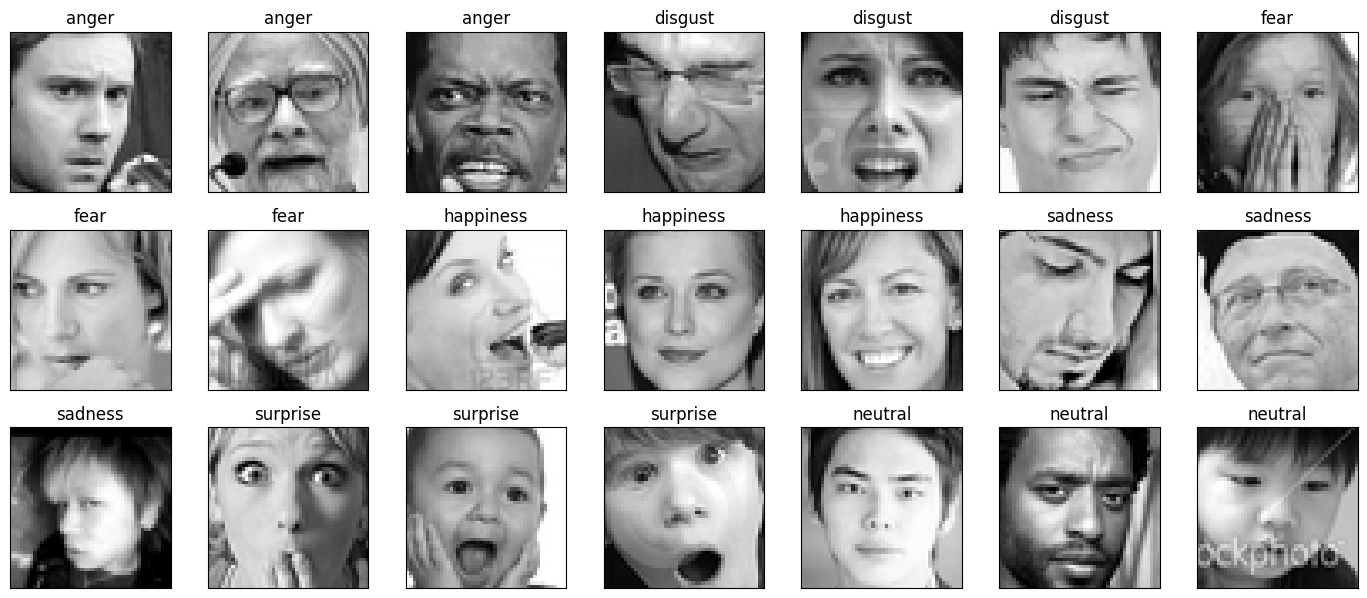

In [10]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [11]:
INTERESTED_LABELS = [0,1,2,3, 4,5, 6]

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [13]:
img_array.shape

(35887, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [15]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### Spliting the data for training

In [16]:
# Initial train-test split (85% training, 15% testing)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.15, random_state=42
)



In [17]:
# Further split the training data into training (90% of 85%) and validation sets (10% of 85%)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, shuffle=True, stratify=y_train_full, test_size=0.1, random_state=42
)

In [18]:
# Display shapes of datasets
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(27452, 48, 48, 1) (3051, 48, 48, 1) (5384, 48, 48, 1)
(27452, 7) (3051, 7) (5384, 7)


In [19]:
del df
del img_array
del img_labels

In [20]:
# Normalize the training and validation data
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [21]:
# Create tf.data.Dataset objects for training, validation, and test datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# Define a function for data augmentation
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    return image, label

In [22]:
# Apply augmentation and batching
batch_size = 32
train_dataset = (train_dataset
                 .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(buffer_size=1000)
                 .batch(batch_size)
                 .prefetch(buffer_size=tf.data.AUTOTUNE))

valid_dataset = (valid_dataset
                 .batch(batch_size)
                 .prefetch(buffer_size=tf.data.AUTOTUNE))

test_dataset = (test_dataset
                .batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE))

In [23]:
# Model preparation
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]


### Model Building

In [24]:
def build_net(optim):
    net = Sequential(name='CNN')

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.3, name='dropout_1'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.3, name='dropout_2'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            256,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.5, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [25]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [26]:
#Optimizers
optims = [
    optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.0001),
]
epochs = 30
model = build_net(optims[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 128)         │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,567,111 (36.50 MB)

 Trainable params: 9,563,015 (36.48 MB)

 Non-trainable params: 4,096 (16.00 KB)

### Training the Model

In [27]:
# Training the model with tf.data.Dataset
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 93s 86ms/step - accuracy: 0.1898 - loss: 2.6513 - val_accuracy: 0.3478 - val_loss: 1.7304 - learning_rate: 1.0000e-04
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 64s 74ms/step - accuracy: 0.2658 - loss: 2.0736 - val_accuracy: 0.3871 - val_loss: 1.6436 - learning_rate: 1.0000e-04
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - accuracy: 0.3192 - loss: 1.8964 - val_accuracy: 0.4025 - val_loss: 1.6398 - learning_rate: 1.0000e-04
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 82s 72ms/step - accuracy: 0.3630 - loss: 1.7298 - val_accuracy: 0.4267 - val_loss: 1.4947 - learning_rate: 1.0000e-04
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 62s 72ms/step - accuracy: 0.4028 - loss: 1.6076 - val_accuracy: 0.4913 - val_loss: 1.3703 - learning_rate: 1.0000e-04
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 82s 72ms/step - accuracy: 0.4319 - loss: 1.5083 - val_accuracy: 0.5077 - val_loss: 1.3014 - learning_rate: 1.0000e-04
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 63s 74ms/ste

In [28]:
# Save the entire model
model.save('/content/drive/MyDrive/FER file/model.keras')


Accuracy and Loss Curve

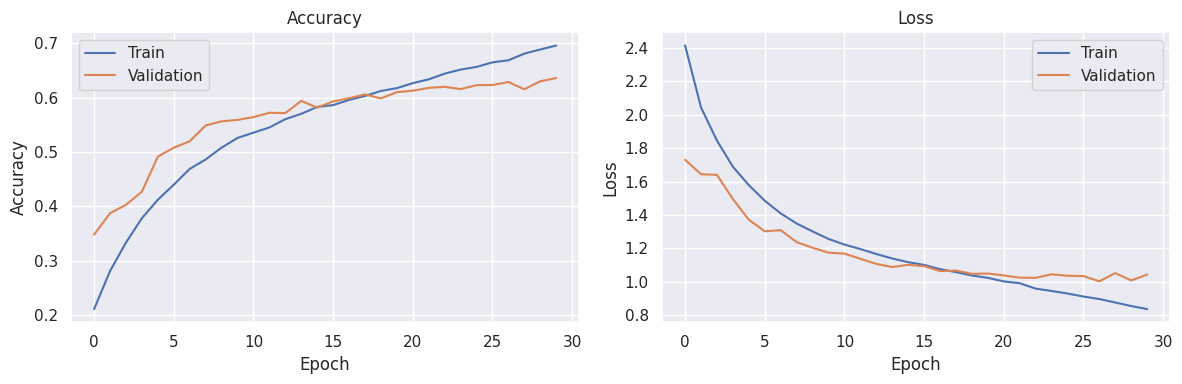

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set()

# Create a figure with two subplots
fig = plt.figure(0, figsize=(12, 4))

# Accuracy subplot
ax1 = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train', ax=ax1)
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation', ax=ax1)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss subplot
ax2 = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train', ax=ax2)
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation', ax=ax2)
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('epoch_history_dcnn.png')

# Show the plot
plt.show()


### Model Performance

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


<Figure size 700x700 with 0 Axes>

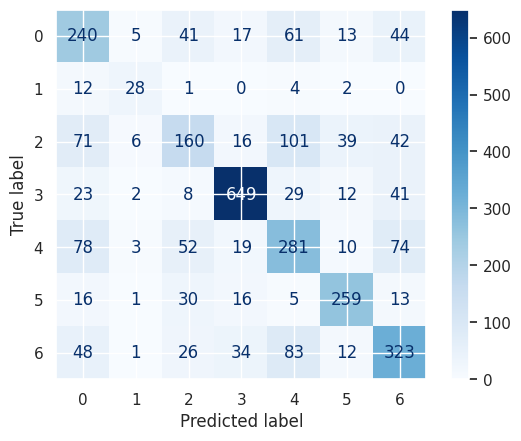

Total wrong validation predictions: 1111


Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.57      0.53       421
           1       0.61      0.60      0.60        47
           2       0.50      0.37      0.42       435
           3       0.86      0.85      0.86       764
           4       0.50      0.54      0.52       517
           5       0.75      0.76      0.75       340
           6       0.60      0.61      0.61       527

    accuracy                           0.64      3051
   macro avg       0.62      0.61      0.61      3051
weighted avg       0.64      0.64      0.63      3051

Validation Accuracy: 0.6359
858/858 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step
Training Accuracy: 0.7785


In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Generate predictions for the validation set
yhat_valid = model.predict(X_valid)

# Convert one-hot encoded predictions and labels to class indices
y_true = np.argmax(y_valid, axis=1)
y_pred = np.argmax(yhat_valid, axis=1)

# Compute the confusion matrix for validation set
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6']  # Replace with your actual class names

# Set figure size before plotting
plt.figure(figsize=(7, 7))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

# Save the confusion matrix plot
plt.savefig("confusion_matrix_dcnn.png")

# Show the plot
plt.show()

# Print the total number of wrong validation predictions
print(f'Total wrong validation predictions: {np.sum(y_true != y_pred)}\n\n')

# Print the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Calculate and print the validation accuracy
validation_accuracy = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {validation_accuracy:.4f}')

# Generate predictions for the training set
yhat_train = model.predict(X_train)  # Assuming X_train is your training data

# Convert one-hot encoded predictions and labels to class indices for training set
y_true_train = np.argmax(y_train, axis=1)  # Assuming y_train is your training labels
y_pred_train = np.argmax(yhat_train, axis=1)

# Calculate and print the training accuracy
training_accuracy = accuracy_score(y_true_train, y_pred_train)
print(f'Training Accuracy: {training_accuracy:.4f}')

Accuracy on Test Dataset

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Generate predictions for the test set
yhat_test = model.predict(X_test)

# Convert one-hot encoded predictions and labels to class indices for test set
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(yhat_test, axis=1)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_true_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy:.4f}')


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
Test Accuracy: 0.6304
